# PCM correlation models 
This demo shows two ways to use PCM models to test hypotheses about the correlation between activity patterns. 

- In the first part of this jupyter notebook, we'll focus on how to assess the **true** correlation between two activity patterns. 


- In the second part, we will consider a slightly more complex situation in which we want to estimate the true correlation between two **sets** of activity patterns measured under two different conditions. 
    
>For example, we might want to know how the activity patterns related to the observation of 3 hand gestures correlate (at a gesture-specific level) with the activity patterns related to the execution of the same 3 hand gestures.

In [31]:
# First import necessary libraries
#(make sure PcmPy is in your python path)
import PcmPy as pcm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import exp, sqrt
import scipy.stats as sps

## 1. Estimating the true correlation between two patterns
How similar/correlated are two activity patterns? It is easy to test whether 2 activity patterns are more correlated than chance (i.e., zero correlation). However, even if the two conditions elicit exactly the same pattern, the correlation will not be 1, simply because of measurement noise. Thus, it is very hard to estimate the **true** correlation between condition **A** and **B**. As explained in our blog [*Brain, Data, and Science*](http://diedrichsenlab.org/BrainDataScience/noisy_correlation), cross-validation does not result in unbiased estimates.

To solve this problem, PCM turns the problem around: rather than asking which correlation is the best estimate given the data, let's instead ask how likely the data is given different levels of correlations. Thus, we will calculate the likelihood of the data given a range of specific correlations, $p(Y|r)$, and then compare this likelihood across a range of correlation models. 

In estimating the likelihood, we also need to estimate two additional model parameters: 
- The strength (variance across voxels) of the activity patterns associated with condition **A**. 
- The strength (variance across voxels) of the activity patterns associated with condition **B**. 

And one additional noise parameter: 
- The variance of the measurement noise across repeated measures of the same pattern. 

These hyper-parameters are collectively referred to by $\theta$ (thetas). Here we will compare different models by using the (Type II) maximum likelihood to approximate the model evidence:

$$
p(Y|r) \approx \underset{\theta}{\operatorname{max}}{p(Y|r,\theta)}.
$$

>This may seem like a bit of a cheat, but works in this case quite well. Estimating parameters on the same data that you use to evaluate the model of course leads to an overestimation of the likelihood. 

>However, as the number of hyper-parameters is low and all correlation models have the same number of parameters, this bias will be approximately stable across all models. Since we are interested in the *difference* in log-likelihood across models, this small bias simply disappears. 

>If you want to compare models with different numbers of parameters, a more sophisticated approach (such as group-cross-validation) is required. 

### 1.1 Simulating the data
We will use the PCM toolbox to simulate data from a given model of the underlying true (noiseless) correlation between two activity patterns (`Mtrue`). In this example, we set that our two activity patterns are positively correlated with a true correlation of 0.7.

>Note that in `pcm.CorrelationModel` we set `num_items` to 1, as we have only 1 activity pattern per condition, and we set `cond_effect` to `False`, as we do not want to model the overall effect between different conditions (each with multiple items, see section 2 below).

The true model (`Mtrue`) has 2 hyper-parameters reflecting the signal strength (or true pattern variance) for each activity pattern (`item`). In addition to the 2 model parameters, PCM also fits one parameter for the variance of the measurement noise.


In [32]:
Mtrue = pcm.CorrelationModel('corr', num_items=1, corr=0.7, cond_effect=False)
print(f"The true model has {Mtrue.n_param} hyper parameters")

The true model has 2 hyper parameters


We can now use the simulation module to create 20 datasets (e.g., one per simulated participant) with a relatively low signal-to-noise level (0.2:1). We will use a design with 2 conditions and 8 partitions/runs per dataset.
>Note that the thetas are specified as log(variance).

In [33]:
# Create the design. In this case it's 2 conditions, across 8 runs (partitions)
cond_vec, part_vec = pcm.sim.make_design(n_cond=2, n_part=8)

# Starting from the true model above, generate 20 datasets/participants 
# with relatively low signal-to-noise ratio (0.2:1)
# Note that signal variance is 0.2 - noise variance is by default set to 1 
# For replicability, we are using a fixed random seed (100)
rng = np.random.default_rng(seed=100)
D = pcm.sim.make_dataset(model=Mtrue, \
    theta=[0,0], \
    cond_vec=cond_vec, \
    part_vec=part_vec, \
    n_sim=20, \
    signal=0.2,\
    rng=rng)

First let's look at the correlation that we get when we calculate the *naive* correlation—i.e. the correlation between the two estimated activity patterns. 

In [34]:
def get_corr(X,cond_vec):
    """
        Get normal correlation
    """
    p1 = X[cond_vec==0,:].mean(axis=0)
    p2 = X[cond_vec==1,:].mean(axis=0)
    return np.corrcoef(p1,p2)[0,1]

r = np.empty((20,))
for i in range(20):
    data = D[i].measurements
    r[i] = get_corr(data, cond_vec)
print(f'Estimated mean correlation: {r.mean():.4f}')

Estimated mean correlation: 0.4127


As we can see, due to measurement noise, the estimated mean correlation is much lower than the true value of 0.7.

This is not a problem if we just want to test the hypothesis that the true correlation is larger than zero. Then we can just calculate the individual correlations per subject and test them against zero using a t-test. 

However, if we want to test whether the true correlation has a specific value (for example `true_corr=1`, indicating that the activity patterns are the same), or if we want to test whether the correlations are higher in one brain area than another, then this becomes an issue. 

Different brain regions measured with fMRI often differ dramatically in their signal-to-noise ratio. Thus, we need to take into account our level of measurement noise. PCM can do that.

### 1.2 Fitting the data
We can solve this problem by making a series of PCM correlation models in the range e.g., [0 1] (or -1 to 1 if you want). We also generare a flexible model (`Mflex`) that has the correlation as a parameter that is being optimized. 

In [35]:
nsteps = 20 # how many correlation models?  
M = [] # initialize the output list M

# Generate the models equally spaced between 0 and 1 
for r in np.linspace(0, 1, nsteps):
    M.append(pcm.CorrelationModel(f"{r:0.2f}", num_items=1, corr=r, cond_effect=False))
    
# Now make the flexible model 
Mflex = pcm.CorrelationModel("flex", num_items=1, corr=None, cond_effect=False)
M.append(Mflex)

We can now fit the models to the datasets in one go. The resulting dataframe `T` has the log-likelihoods for each model (columns) and dataset (rows). The second return argument `theta` contains the parameters for each model fit. 

In [36]:
# In this case, we model the block effect as a mixed effect
# We don't need to include a scale parameter given that we don't have a fixed model 
T, theta = pcm.fit_model_individ(D, M, fixed_effect=None, fit_scale=False, verbose=False)
T.head()

variable  likelihood                                                  \
model           0.00        0.05        0.11        0.16        0.21   
0        -234.937150 -234.793421 -234.679377 -234.594949 -234.540553   
1        -249.115550 -248.445834 -247.806381 -247.194513 -246.608029   
2        -278.140577 -277.923649 -277.723567 -277.539976 -277.372656   
3        -262.453736 -261.949207 -261.472521 -261.021806 -260.595609   
4        -254.133454 -253.676709 -253.248643 -252.847649 -252.472559   

variable                                                              ...  \
model           0.26        0.32        0.37        0.42        0.47  ...   
0        -234.517117 -234.526138 -234.569756 -234.650865 -234.773248  ...   
1        -246.045157 -245.504529 -244.985186 -244.486599 -244.008726  ...   
2        -277.221540 -277.086717 -276.968453 -276.867193 -276.783574  ...   
3        -260.192870 -259.812921 -259.455499 -259.120782 -258.809456  ...   
4        -252.122629 -251.797543 -251.497447 -251.222995 -250.975441  ...   

variable iterations                                               
model          0.58 0.63 0.68 0.74 0.79 0.84 0.89 0.95 1.00 flex  
0               4.0  4.0  5.0  5.0  5.0  6.0  7.0  8.0  9.0  4.0  
1               4.0  4.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0  6.0  
2               3.0  3.0  3.0  3.0  3.0  3.0  4.0  4.0  4.0  5.0  
3               3.0  3.0  3.0  3.0  3.0  2.0  3.0  3.0  4.0  5.0  
4               3.0  3.0  3.0  3.0  3.0  3.0  4.0  4.0  4.0  5.0  

[5 rows x 63 columns]

### 1.3 Interpreting the fit 
Note that the log-likelihood values are negative and differ substantially across datasets. This is normal—the only thing we can interpret are differences between log-likelihoods across the same data set for different models.

Therefore, first, we remove the mean log-likelihood for each dataset across correlation models, expressing each log-likelihood as the difference from the mean.

Next, we plot the full log-likelihood curves (solid lines) and the maximum likelihood estimate (filled circles) of the correlation for each participant. We can also add the mean log-likelihood curve (dotted line) and the mean of the maximum log-likelihood estimates (vertical blue line) across participants.

Text(0,0.5,'log-likelihood')

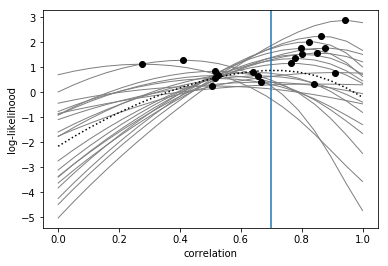

In [37]:
L = T.likelihood.to_numpy()

# express log-likelihoods relative to mean 
L = L - L.mean(axis=1).reshape(-1,1)
maxL = L[:,-1] # Last model is the flexible 
L = L[:,0:-1] # Remove it 

# Get the correlation for each of the models
r = np.empty((nsteps,))
for i in range(nsteps):
    r[i] = M[i].corr

# Get the maximum likelihood estimate of each parameter 
maxr = M[-1].get_correlation(theta[-1])

# Now we make the plot: 
# Plot the individual log-liklihood curves and their peak in gray lines: 
plt.plot(r, L.T, color='gray', marker=None, linewidth=1)
plt.plot(maxr, maxL, 'k.', markersize=12)

# Plot the mean of the maximum-liklihood estimates in a vertical line 
plt.axvline(maxr.mean())

# Plot the mean of the likelihood curves as a dashed line 
plt.plot(r,L.mean(axis=0), 'k:')
plt.xlabel('correlation')
plt.ylabel('log-likelihood')

As we can see, the maximum-likelihood estimates (filled circles) behave quite well, as they are at least around the true correlation value (0.7). 

However, the mean of the maximum-likelihood estimates (vertical line) is unfortunately not unbiased but slightly biased towards zero (see [*Brain, Data, and Science blog*](http://diedrichsenlab.org/BrainDataScience/noisy_correlation)). Therefore, best way to use the log-likelihoods is to do a paired-samples t-test between the log-likelihoods for two correlation values.

For example, 0.7 vs. 1, or 0.7 vs. 0: 

In [38]:
print(f"Testing correlation of {r[13]:0.2f} against {r[19]:0.2f}")
t, p = sps.ttest_rel(L[:,13],L[:,19])
print(f'Paired-samples t-test: t({len(L)-1})={t:1.3f}; p({len(L)-1})={p:1.6f}\n')

print(f"Testing correlation of {r[13]:0.2f} against {r[0]:0.2f}")
t, p = sps.ttest_rel(L[:,13],L[:,0])
print(f'Paired-samples t-test: t({len(L)-1})={t:1.3f}; p({len(L)-1})={p:1.6f}')

Testing correlation of 0.68 against 1.00
Paired-samples t-test: t(19)=3.334; p(19)=0.003491

Testing correlation of 0.68 against 0.00
Paired-samples t-test: t(19)=6.101; p(19)=0.000007


Thus, we have clear evidence that the correlation of 0.68 is more likely than a correlation of zero (i.e., that the patterns are unrelated), and more likely than a correlation of one (i.e., that the patterns are identical).  

## 2. Testing for specific correlations between activity patterns across two conditions
In the second part of this notebook, we will simulate data from a hypothetical experiment, in which participants observed 3 hand gestures or executed the same 3 hand gestures. Thus, we have 3 items (i.e., the hand gestures) in each of 2 conditions (i.e., either observe or execute). 

We are interested in the average correlation between the patterns associated with observing and executing action A, observing and executing action B, and observing and executing action C, while accounting for overall differences in the average patterns of observing and executing. To solve this problem, we again calculate the likelihood of the data given a range of specific correlations $p(Y|r)$.

In this case we have a few more additional hyper-parameters to estimate: 
- The variance of the movement-specific activity patterns associated with observing actions.
- The variance of the movement-specific activity patterns associated with executing actions.


>These hyper-parameters express the strength of encoding and are directly related to the average inter-item distance in an RSA analysis.


- The variance of the pattern component that is common to all observed actions. 
- The variance of the pattern component that is common to all executed actions. 


- Finally, we again have a hyper-parameter for the noise variance. 

### 2.1 Data simulation
First, we create our true model (`Mtrue`): one where the all actions are equally strongly encoded in each condition, but where the strength of encoding can differ between conditions (i.e., between observation or execution). 

>For example, we could expect the difference between actions to be smaller during observation than during execution (simply due to overall levels of brain activation). 

Next, we also model the covariance between items within each condition with a condition effect (i.e., by setting `condEffect` to `True`). Finally, we set the ground-truth correlation to be 0.7. 

In [39]:
Mtrue = pcm.CorrelationModel('corr', num_items=3, corr=0.7, cond_effect=True, within_cov=None)
print(f"The true model has {Mtrue.n_param} hyper parameters")

The true model has 4 hyper parameters


These four parameters are concerned with the condition effect and item effect for observation and execution, respectively. Visualizing the components of the second moment matrix (also known as variance-covariance, or simply covariance matrix) helps to understand this:

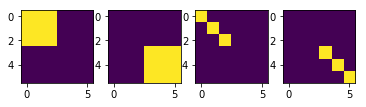

In [40]:
H = Mtrue.n_param
for i in range(H):
    plt.subplot(1, H, i+1)
    plt.imshow(Mtrue.Gc[i,:,:])

>The first two components plotted above reflect the condition effect and model the covariance between items within each condition (observation, execution). The second two components reflect the item effect and model the item-specific variance for each item (3 hand gestures) in each condition.

To Simulate a dataset, we need to simulate an experimental design. Let's assume we measure the 6 trial types (3 items x 2 conditions) in 8 imaging runs and submit the beta-values from each run to the model as $\mathbf{Y}$. 

We then generate a dataset where there is a strong overall effect for both observation (exp(0)) and execution (exp(1)). In comparison, the item-specific effects for observation (exp(-1.5)) and execution (exp(-1)) are pretty weak (this is a rather typical finding).

>Note that all hyper parameters are log(variances)—this helps us to keep variances positive and the math easy. 

In [41]:
# Create the design. In this case it's 8 runs, 6 trial types
cond_vec, part_vec = pcm.sim.make_design(n_cond=6, n_part=8)
#print(cond_vec)
#print(part_vec)

# Starting from the true model above, generate 20 datasets/participants 
# with relatively low signal-to-noise ratio (0.2:1)
D = pcm.sim.make_dataset(model=Mtrue, \
    theta=[1,2.7,0.4,0.2], \
    cond_vec=cond_vec, \
    part_vec=part_vec, \
    n_sim=20, \
    signal=0.2)

As a quick check, let's plot the predicted second moment matrix of our true model (using the simulation parameters) and the crossvalidated estimate from the first dataset. 

Text(0.5,1,'dataset')

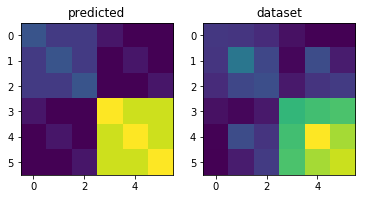

In [42]:
# Get the predicted G-matrix  from the true model
G,_ = Mtrue.predict([1,2.7,0.4,0.2])

# The estimated G-matrix from the first dataset 
trial_type = D[1].obs_descriptors['cond_vec']
G_hat,_ = pcm.est_G_crossval(D[1].measurements, trial_type, part_vec)

# Visualize the second moment (G) matrices
plt.subplot(1,2,1)
plt.imshow(G)
plt.title('predicted')

plt.subplot(1,2,2)
plt.imshow(G_hat)
plt.title('dataset')

### 2.2 Fitting the data 
Now we are fitting these datasets with a range of models, each assuming a correlation value between 0 and 1. The other parameters will still be included, as we did for the true model.

For comparison, we also include a flexible correlation model (`Mflex`), which has a additional free parameter that models the correlation.

In [44]:
nsteps = 100 # how many correlation models?  
M = [] # initialize the output list M

# Generate the models equally spaced between 0 and 1 
for r in np.linspace(0, 1, nsteps):
    M.append(pcm.CorrelationModel(f"{r:0.2f}", num_items=3, corr=r, cond_effect=True))
    
# Now make the flexible model 
Mflex = pcm.CorrelationModel("flex", num_items=3, corr=None, cond_effect=True)
M.append(Mflex)

We can now fit the model to the datasets in one go. The resulting dataframe `T` has the log-likelihoods for each model (columns) / dataset (rows). The second return argument `theta` contains the parameters for each model fit. 

In [45]:
# In this case, we model the block effect as a mixed effect
# We don't need to include a scale parameter given that we don't have a fixed model 
T, theta = pcm.fit_model_individ(D, M, fixed_effect='block', fit_scale=False, verbose=False)
T.head()

variable  likelihood                                                  \
model           0.00        0.01        0.02        0.03        0.04   
0        -887.831487 -887.705964 -887.582884 -887.462226 -887.343969   
1        -897.418265 -897.100121 -896.784548 -896.471492 -896.160898   
2        -938.057184 -937.851286 -937.647757 -937.446563 -937.247669   
3        -938.816255 -938.592624 -938.371687 -938.153403 -937.937735   
4        -875.956085 -875.773279 -875.593541 -875.416842 -875.243151   

variable                                                              ...  \
model           0.05        0.06        0.07        0.08        0.09  ...   
0        -887.228095 -887.114588 -887.003433 -886.894614 -886.788120  ...   
1        -895.852715 -895.546892 -895.243381 -894.942133 -894.643103  ...   
2        -937.051042 -936.856650 -936.664465 -936.474457 -936.286599  ...   
3        -937.724648 -937.514106 -937.306077 -937.100530 -936.897437  ...   
4        -875.072443 -874.904691 -874.739873 -874.577969 -874.418959  ...   

variable iterations                                               
model          0.92 0.93 0.94 0.95 0.96 0.97 0.98 0.99 1.00 flex  
0               6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  5.0  
1               6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  7.0  
2               5.0  5.0  5.0  5.0  5.0  5.0  5.0  5.0  5.0  5.0  
3               6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  
4               6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  5.0  

[5 rows x 303 columns]

### 2.3 Interpreting the Fit 
Again, note that the absolute values of the log-likelihoods don't mean much. Therefore, first, we remove the mean log-likelihood for each correlation model, expressing each log-likelihood as the difference against the mean. 

Next, we plot the full log-likelihood curves (solid lines) and the maximum likelihood estimate (filled circles) of the correlation for each participant. We can also add the mean log-likelihood curve (dotted line) and the mean of the maximum log-likelihood estimates (vertical blue line) across participants.

Text(0,0.5,'log-likelihood')

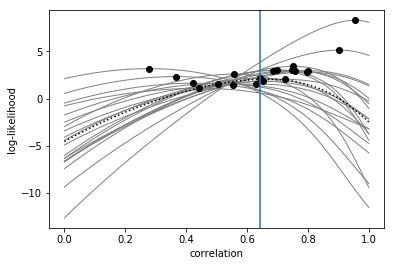

In [46]:
L = T.likelihood.to_numpy()

# express log-likelihoods relative to mean 
L = L - L.mean(axis=1).reshape(-1,1)
maxL = L[:,-1] # Last model is the flexible 
L = L[:,0:-1] # Remove it 

# Get the correlation for each of the models
r = np.empty((nsteps,))
for i in range(nsteps):
    r[i]= M[i].corr

# Get the maximum likelihood estimate of each parameter 
maxr = M[-1].get_correlation(theta[-1])

# Now we make the plot 
plt.plot(r, L.T, color='gray', marker=None, linewidth=1)
plt.plot(maxr, maxL, 'k.', markersize=12)
plt.plot(r, L.mean(axis=0), 'k:')
plt.axvline(maxr.mean())
plt.xlabel('correlation')
plt.ylabel('log-likelihood')


Again, the best way to use the log-likelihoods is to do a paired-samples t-test between the log-likelihoods for two correlation values: e.g., 0.7 vs 0.3:

In [48]:
print(f"Testing correlation of {r[69]:0.2f} against {r[30]:0.2f}")
t, p = sps.ttest_rel(L[:,69], L[:,30])
print(f'nPaired-samples t-test: t({len(L)-1})={t:1.3f}; p({len(L)-1})={p:1.6f}')

Testing correlation of 0.70 against 0.30
nPaired-samples t-test: t(19)=3.331; p(19)=0.003513


Thus, we have clear evidence that the true correlation is much more likely to be 0.7 than 0.3. 

Alternatively, we can transform the log-likelihoods in approximate posterior distributions, and proceed with a Full Bayesian group analysis. 
For more accurate results, you probably want to space your correlation models more tightly.

Text(0,0.5,'posterior probability')

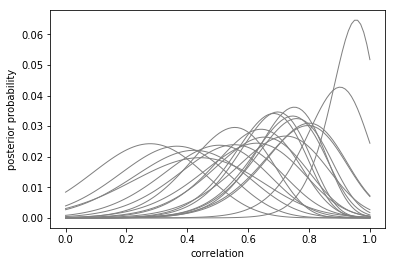

In [49]:
P = exp(L) # Take the exponential of the log-likelihoods
P = P / P.sum(axis=1).reshape(-1,1) # Normalize to 1 over domain 
plt.plot(r, P.T, color='gray', marker=None, linewidth=1)
plt.xlabel('correlation')
plt.ylabel('posterior probability')